In [67]:
import numpy as np
import pandas as pd
import time
import datetime
import math
import seaborn as sns
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import plotly
import plotly.express as px
import plotly.offline as pyo
import cufflinks as cf 
from plotly.offline import init_notebook_mode,plot,iplot
import matplotlib.pyplot as plt
%matplotlib inline
pyo.init_notebook_mode(connected=True)
cf.go_offline()   # bind pandas and plotly together

#### Function for Geodesic Distance

In [68]:
def haversine(coord1, coord2):

## Geodesic distance from 2 coordinates, used when we deal with oblate spheroid to be exact
## haversine formula is used to calculate this

    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))


In [69]:
class merge:
    def pm_aqi(self,pmdata,aqi):

        ## info taken from AQI dataset
        locate = pd.DataFrame(['BSRI','KN','NS','PMPR','SWGT'],columns=['location'])
        
        ## here we take mean values from the AQI dataset EDA, but we need to perform it dynamically
        quality = [128,94,124,103,113]
        quality_18 = [117,87,118,97,110]
        quality_19 = [169,125,147,133,142]
        
        ## latitude and longitude according to google map
        lati = [18.6321,18.4915,18.5081,18.6298,18.5000]
        longi = [73.8468,73.8217,73.8313,73.7997,73.8590]
        
        locate['quality'] = quality
        locate['quality_18'] = quality_18
        locate['quality_19'] = quality_19
        locate['latitude'] = lati
        locate['longitude'] = longi
        
        pmdata['Station'] = 0
        pmdata['AQI'] = 0
        pmdata['AQI_18'] = 0
        pmdata['AQI_19'] = 0

        distance = []
        for i in pmdata.index:
            ## latitude and longitude of our pm dataset, we will calculate distance from this coordinate to every coordinate of station
            la,lo=pmdata['LAT'][i],pmdata['LONG'][i]


            for j in range(len(locate)):
                ## for every coordinate of pmdata, there will be 5 distances to each station
                distance = [haversine((la,lo),(locate['latitude'][k],locate['longitude'][k])) for k in range(len(locate)) ]
                ## we will find minimum distance. And because this is Geodesic distance, we will assign the coordiates with the nearest station
                min_dis = np.min(distance)
                min_index = distance.index(min(distance))

                pmdata['Station'][i] = locate['location'][min_index]
                #pmdata['Distance from central point'] = 
                pmdata['AQI'][i] = locate['quality'][min_index]
                pmdata['AQI_18'][i] = locate['quality_18'][min_index]
                pmdata['AQI_19'][i] = locate['quality_19'][min_index]


            distance=[]
        
        return(pmdata)

    
    def pm_tree(self,pmdata,treedata):
        #sorting data based latitude and longitude
        pmdata.sort_values(["LAT","LONG"], axis = 0, ascending = [True,True],inplace = True, na_position ='first')
        treedata.sort_values(["latitude","longitude"], axis = 0, ascending = [True,True],inplace = True, na_position ='first')
        ## dropping irrelevant features
        treedata.drop(['girth_cm','height_m', 'canopy_dia_m', 'condition','other_remarks','ownership', 'society_name', 'road_name','balanced', 'remarks', 'special_collar', 'ward_name','sr_no','botanical_name', 'saar_uid', 'common_name', 'local_name', 'economic_i',
       'phenology', 'flowering', 'ward', 'is_rare'],axis=1, inplace=True)
        ## slicing treedata to parse
        treedata = treedata.iloc[2500000:2600000,:]     
        #concatinate total pm 2.5 datafarme with other columns
        PM_25=pmdata[['PM25_IND','PM25_OTH','PM25_POW','PM25_RES','PM25_TRN','PM25_WB']].sum(axis=1)
        pmdata = pd.concat([pmdata, PM_25], axis=1, sort=False)
        #rename total pm 2.5 column as PM
        pmdata.rename(columns={0:"PM"},inplace=True)
           
        pmdata['Trees']=0
        ## a counter that prints when each grid is covered
        m=0                  
        
        for i in pmdata.index:
            la,lo=pmdata['LAT'][i],pmdata['LONG'][i]

            for j in treedata.index:
               
                ## for a particular coordinate in pmdata, it will calculate the distance to the each coordinate of treedata
                
                distance = haversine((la,lo),(treedata['latitude'][j],treedata['longitude'][j]))
                
                ## if this distance is less than equal to 250 from a particular coordinate in pmdata, then for that coordinate, trees 
                ## count is increased by 1 and then it will check further more for other tree coordinates if they fall in same grid. 
                ##So for a coordinate in pmdata it will form a 500*500 circular grid around that point with diameter 500m
            
                if(distance<=250.0):
                    pmdata['Trees'][i] = pmdata['Trees'][i] + 1
                    treedata.drop(treedata.index,axis=0,inplace=True)       
            m+=1
            print(m)

        return(pmdata)
    

In [70]:
class visualization:
    def AQI_plot(self,pmdata):
        sns.lmplot('LAT','LONG', pmdata, hue='AQI', fit_reg=False)
        fig = plt.gcf()
        fig.set_size_inches(10, 8)
        plt.title("Total AQI plot")
        plt.show()

    def AQI_18_plot(self,pmdata):
        sns.lmplot('LAT','LONG', pmdata, hue='AQI_18', fit_reg=False)
        fig = plt.gcf()
        fig.set_size_inches(10, 8)
        plt.title("AQI Plot of 2018 year")
        plt.show()

    def AQI_19_plot(self,pmdata):
        sns.lmplot('LAT','LONG', pmdata, hue='AQI_19', fit_reg=False)
        fig = plt.gcf()
        fig.set_size_inches(10, 8)
        plt.title("AQI plot of 2019 year")
        plt.show()
        
    def Station_voronoi(self,pmdata):
        plt.figure(figsize=(10,10))
        plt.title("Station wise plot based on latitude and longitude")
        color_dict = dict({'BSRI':'brown',
                          'KN':'green',
                          'NS': 'orange',
                          'PMPR': 'red',
                          'SWGT': 'dodgerblue'})

        g = sns.scatterplot('LAT','LONG', hue="Station",
                      data=pmdata, palette=color_dict, 
                           legend='full')
        g.set(xscale="log")
    
    def Actual_data_plot_3d(self,df):
        fig = px.scatter_3d(df, x='PM', y='Trees', z='AQI', color='Station',title='Actual 3D data plot')
        fig.show()
        
    def Data_plot_2d(self,x,yy,title):       
        plt.scatter(x.iloc[yy == 94, 0], x.iloc[yy == 94, 1],s=50, c='green', label='KN')

        plt.scatter(x.iloc[yy == 103, 0], x.iloc[yy == 103, 1],s=50, c='orange',label='PMPR')

        plt.scatter(x.iloc[yy == 113, 0], x.iloc[yy == 113, 1],s=50, c='lightblue',label='SWGT')

        plt.scatter(x.iloc[yy == 124, 0], x.iloc[yy == 124, 1],s=50, c='pink',label='NS')

        plt.scatter(x.iloc[yy == 128, 0], x.iloc[yy == 128, 1],s=50, c='yellow',label='BSRI')

        plt.title(title)
        plt.legend()
        plt.grid()
        plt.show()
        
        
    def Predicted_data_plot_3D(self,x_test_std,predict_knn,title):
        fig = px.scatter_3d(x=x_test_std[:,0], y=x_test_std[:,1], z=predict_knn, color=predict_knn, title=title)
        fig.show()                                                   ## z is Predicted AQI
        
        
    def swarm(self,project_data):
        sns.swarmplot(x="Station", y="Trees", data=project_data)
                
    def px_scatter1(self,project_data):
        fig = px.scatter(project_data,x='Station',y='Trees',hover_data=['LAT','LONG','PM','AQI'],title='Brief info of Dataset',color='Station',size='Trees')
        fig.show()
        
    def px_scatter2(self,df):
        fig = px.scatter(df,x='LAT',y='LONG',hover_data=['Trees','AQI','PM'],title='Brief info of Dataset',color='Station',size='PM')
        fig.show()
        
    def px_bar(self,df):
        fig = px.bar(df,x='Station',y='Trees',hover_data=['LAT','LONG','Trees','AQI','PM'],title='Analysis of PM,AQI,TREES')
        fig.show()
        
    def px_scatter3(self,df):
        fig = px.scatter_matrix(df,color='Station',title='Scatter',dimensions=['AQI','PM','Trees'])
        fig.show()

In [71]:
class model:
    def knn(self,k,x_train_std,y_train,x_test_std,y_test):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train_std,y_train)
        
        predict_knn_test = knn.predict(x_test_std)
        predict_knn_train = knn.predict(x_train_std)
        
        accuracy_knn = accuracy_score(y_test,predict_knn_test)
        print(accuracy_knn)
        
        train_acc = accuracy_score(y_train,predict_knn_train)
        return(predict_knn_test,accuracy_knn,train_acc,predict_knn_train)
        #Predicted_data_plot(x_test_std,predict_knn)   ## Predicted plot
        

In [72]:
class preprocessing:   
    def dataprep(self,x):
        #function to remove all records where Trees=0
        x.drop("Unnamed: 0",axis=1,inplace=True) #removing extra column named Unnamed: 0
        data_with_trees=x[x['Trees']!=0]
        return data_with_trees    #returning a new data frame

    def standardize(self,x):
        scalar = StandardScaler().fit(x)
        x = scalar.transform(x)
        return x

    def correlation(self,df):
        corr_matrix = df.corr()
        return corr_matrix.loc[['PM','Trees'],['AQI']]    
        
    def splitting(self,x,y):
        x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.33)
        return(x_train,x_test,y_train,y_test)
    
    def encoding_aqi(self,df):
        df['Encoded_AQI'] = 0
        enc = LabelEncoder()
        return(enc.fit_transform(df['AQI']))
            
    

# Reading Datasets

In [7]:
pmdata=pd.read_excel(r"C:\Users\Shivam\Desktop\project\data\2018-Emissions-Pune-MIT.xlsx")
aqi = pd.read_excel(r"C:\Users\Shivam\Desktop\project\aqi_eda\Air Quality Parameters - MPCB (2018-19 March).xlsx")
treedata=pd.read_csv(r"C:\Users\Shivam\Desktop\project\data\trees_all_clean1.csv")

# Merging Datasets

In [9]:
merge_obj = merge()   ## merge class object created

In [ ]:
project_data = merge_obj.pm_tree(pmdata,treedata)   ## merging pmdata with treedata 

In [ ]:
project_data = merge_obj.pm_aqi(pmdata,aqi)     ## merging with aqi dataset

# Preprocess - Removing Unnecessary Rows and Columns

In [10]:
preprocess = preprocessing()     ## preprocessing class object created 

In [11]:
filter_project_data = preprocess.dataprep(project_data)   ## assigning new dataframe having non-zero to filter_project_data 

#### Coorelations

In [12]:
preprocess.correlation(filter_project_data)

,AQI
PM,0.073931
Trees,-0.154384


# Visualizing Merged Dataset

In [13]:
visual_obj = visualization()     ## creating visualization class object

##### Plotting Total AQI per station

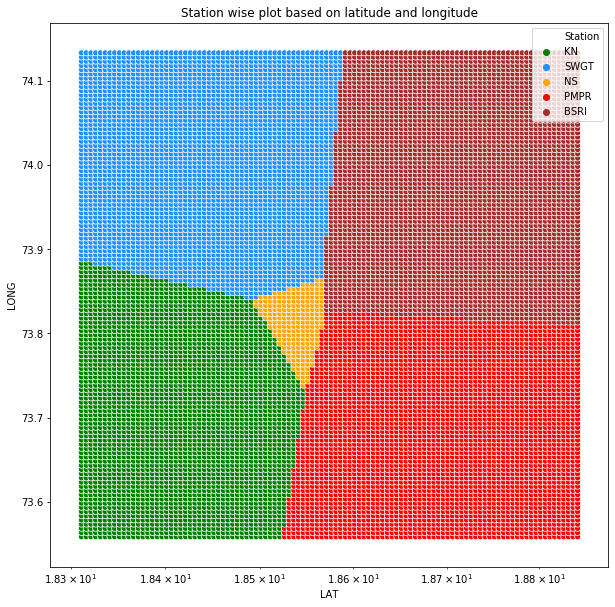

In [17]:
visual_obj.Station_voronoi(project_data)   

##### Swarm plot of Total Trees covered per Station

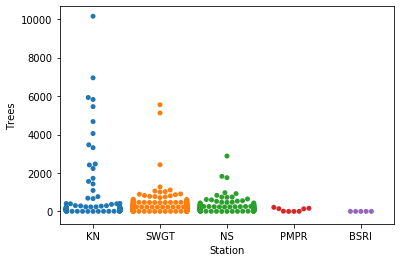

In [18]:
visual_obj.swarm(filter_project_data)    

### Overview of Whole data

In [19]:
visual_obj.px_scatter1(filter_project_data)

In [20]:
visual_obj.px_scatter2(filter_project_data)

In [21]:
visual_obj.px_scatter3(filter_project_data)

In [22]:
visual_obj.px_bar(filter_project_data)

## Creating & Training Model

#### 1. Extract the important features and split them into Train-Test. Since target variable is Categorical, we therefore encoded it.

In [23]:
x=filter_project_data[["PM","Trees",'LAT','LONG']]
y=filter_project_data["AQI"]

In [24]:
x_train,x_test,y_train,y_test = preprocess.splitting(x,y)

In [25]:
filter_project_data['Encoded_AQI'] = preprocess.encoding_aqi(filter_project_data)
filter_project_data.groupby("Station")[['AQI','Encoded_AQI']].max()

,AQI,Encoded_AQI
Station,,
BSRI,128,4
KN,94,0
NS,124,3
PMPR,103,1
SWGT,113,2


#### 2. Standardize them

In [26]:
x_train_std = preprocess.standardize(x_train[['PM','Trees']])

In [27]:
x_test_std = preprocess.standardize(x_test[['PM','Trees']])

#### 3. Train Test and find Accuracy

In [28]:
knn_model = model()    ## creating object for model class

In [29]:
predict_knn, accuracy_knn, train_acc, predict_train = knn_model.knn(9,x_train_std,y_train,x_test_std,y_test)    ## finding train accuracy of model

0.5401785714285714


In [30]:
train_acc   ## finding train accuracy of model

0.5925110132158591

#### 4. Predicted Model Plot-3D

In [31]:
visual_obj.Predicted_data_plot_3D(x_test_std,predict_knn,title="Predicted 3D test model plot KNN")   ## Z is predicted AQI

#### 5. Actual Model Plot-3D

In [32]:
visual_obj.Actual_data_plot_3d(project_data)

#### 6. Predicted testing plot 2D (LAT-LONG, Class - AQI)

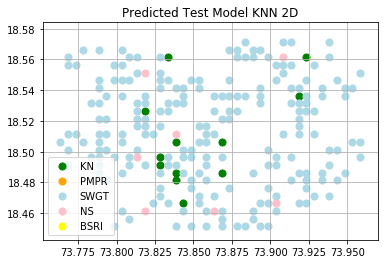

In [21]:
visual_obj.Data_plot_2d(x_test[['LONG','LAT']],predict_knn,"Predicted Test Model KNN 2D")

#### 7. Actual testing plot 2D (LAT-LONG, Class - AQI)

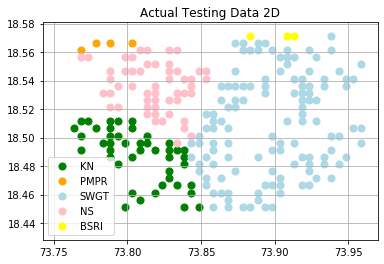

In [22]:
visual_obj.Data_plot_2d(x_test[['LONG','LAT']],y_test.values,"Actual Testing Data 2D")

#### 8. Whole Dataplot 2D (LAT-LONG, Class - AQI)

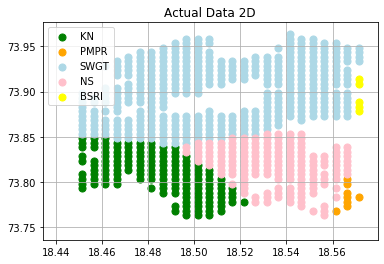

In [33]:
visual_obj.Data_plot_2d(x[['LAT','LONG']],y.values,"Actual Data 2D")